### Table of Contents

* [Functions](#Functions)
* [Exploratory, Data Preprocessing](#Exploratory)
* [Processing Data](#ProcessingData)
    * [Multiclassification Data Prep](#dataprepMulticlassification)
    * [Bianaryclassification Data Prep](#dataprepBianaryclassification)
    * [Observations](#VisByCountObservations)
* [Create Models](#Models)
    * [Bianary Bayes](#BiBayes)
        * [Results/ Confusion Matrix](#BiBayesMatrix)
    * [MultiClass Bayes](#MultiBayes)
        * [Results/ Confusion Matrix](#MultiBayesMatrix)
    * [MultiClass RNN](#RNN)
        * [Results/ Confusion Matrix](#RNNMatrix)
* [Conclusions](#Conclusions)    
* [Create Pickle Files For Modeling](#CreatePickle)   

# Imports/ Libraries

In [8]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import pickle
import seaborn as sns

import spacy
nlp = spacy.load("en_core_web_lg")
from nltk.tokenize import TweetTokenizer
from sklearn.feature_selection import chi2
import nltk
from nltk.probability import FreqDist    
from nltk import word_tokenize
from nltk.util import ngrams 
from imblearn.over_sampling import SMOTE
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
porter=PorterStemmer()

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from collections import Counter
from itertools import chain

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
from spellchecker import SpellChecker


from IPython.display import Markdown, display

from tqdm import tqdm
# tqdm.pandas()

import string
import operator 
import re
from textblob import TextBlob
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import gc
import keras
plt.style.use('fivethirtyeight')



# define model
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SpatialDropout1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings("ignore")

from gensim.models import word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import KeyedVectors



#glove2word2vec(glove_input_file=PTrVec_twitterPath, word2vec_output_file="gensim_glove_vectors.txt")

pd.set_option("max_rows", 1000)
pd.set_option('display.width', None)
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', 200)

In [9]:
df_data_O = pd.read_csv("./data/judge-1377884607_tweet_product_company.csv", engine='python')

# Functions <a class="anchor" id="Functions"></a>

## Misc

In [10]:
def build_vocab(texts):
    """ This funcation takes in a df column and returns the unique word count"""
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def createEmbeddedMatrix1 (name, vocab_size, embedding_dim, embeddings_index):
    '''this function takes in the vocab size of your corpus or #of unique and the size of the vector representing
    your pretrained vector - 100 or 300 in our examples, and the actual pretrained vector indexed by word'''
    skippedwords = 0
    hits = 0
#     global embedding_vector
    # Creating container for embedding
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # get vectors for words that are present in both my vocab and the pretrained word2vec
    if name == "RNN":
        for word, i in t_RNN.word_index.items():
            try:
                embedding_vector = embeddings_index[word]
            except:
                skippedwords = skippedwords+1
                pass
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
        print("Converted %d words (%d misses)" % (hits, skippedwords))
        
    elif name == "TFIDF":
        for word, i in t_tfidf.word_index.items():
            try:
                embedding_vector = embeddings_index[word]
            except:
                skippedwords = skippedwords+1
                pass
            try:
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    hits += 1
            except:
                pass
        print("Converted %d words (%d misses)" % (hits, skippedwords))
        
    elif name == "TFIDF_ex":
        for word, i in t_tfidf_ex.word_index.items():
            try:
                embedding_vector = embeddings_index[word]
            except:
                skippedwords = skippedwords+1
                pass
            try:
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    hits += 1
            except:
                pass
        print("Converted %d words (%d misses)" % (hits, skippedwords))
    
    return embedding_matrix

def getmaxlength(encoded_docs):
    """ This function takes in encoded docs and is used for the RNN model"""
    max_length = 0
    for review_number in range(len(encoded_docs)):
        nuumberofwords=len(encoded_docs[review_number])
        if (nuumberofwords) > (max_length):
            max_length = nuumberofwords
    return max_length


def getSubjectivity(text):
    """This function calculates the subjectivey of a tweet"""
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    """This function calculates the polarity of a tweet"""
    return  TextBlob(text).sentiment.polarity

def check_coverage(name, index, vocab, embeddings_index):
    """This function takes in embedding_idex and returns the coverage your pretrained vec shares with your corpus"""
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass
    print(f'{name} : {index}')
    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

def getCOuntsofPredictedScores(predictions_model):
    """takes in array from .predict() and counts the labels for each class via the model"""
    unique, counts = np.unique(predictions_model, return_counts=True)
    return dict(zip(unique, counts))

def set_weights(y_train, weight = 'balanced', return_class = False, verbose = True):
    """Compute class weights for a given target column. Generate array of sample 
    weights. Optionally, prints a preview of the generated weights and classes.
    Args:
        y_train (list or Series): The target/class data for model.
        weight (str): Type of class balancing to calculate. Defaults to 'balanced'.
        return_class (bool, optional): Whether to return class weights also. 
                                        Defaults to False.
        verbose (bool, optional): Prints dict of classes and weights, previews 
                                        sample weights. Defaults to True.
    Returns:
        np.array: Array of sample weights, one per sample in y_train.
        dict (optional) : keys = classes in target, values = weights
    """
    # Calculate weight per class based upon a specificed distribution of target classes
    class_weights = class_weight.compute_class_weight(class_weight = weight, 
                                                    classes = np.unique(y_train), 
                                                    y = y_train)

    c_weights_dict = dict(zip(np.unique(y_train), class_weights))
    
    # Assign associated class weight to each sample, returns an array of sample length
    sample_weights = class_weight.compute_sample_weight(c_weights_dict, y = y_train)

    if verbose:

        print("Class Weights:", len(class_weights), "classes")
        display(c_weights_dict)

        print("Sample Weights:", len(sample_weights), "samples")
        display(sample_weights)

    if return_class:

        return class_weights, sample_weights
    
    else:

        return sample_weights
    
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(
                      background_color=color,
                      width=2500,
                      height=1500
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    
def plot_confusion_matrix(nameOfMatrix, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(f'{nameOfMatrix} - Normalized confusion matrix here')
    else:
        print(f'{nameOfMatrix} - Confusion matrix, without normalization')

 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Cleanning Functions <a class="anchor" id="ApplyCleanup"></a>

In [11]:
def tweets_cleaning(x, correct_spelling=True, remove_emojis=True):
    """Apply function to a clean a tweet"""
    if correct_spelling:
        x = correct_spellings(x)
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()

    return x

def clean_numbers(x):
    """Removes Numbers from tweets"""
    x = re.sub('[0-9]{5,}', '', x)
    x = re.sub('[0-9]{4}', '', x)
    x = re.sub('[0-9]{3}', '', x)
    x = re.sub('[0-9]{2}', '', x)
    return x


def lemmatization1(texts):
    """Performs lemmatization"""
    texts_out = []
    doc = nlp(texts)
    #using spacey to lemmatize
    texts_out.append([token.lemma_ for token in doc])
    listToStr = ' '.join([str(elem) for elem in texts_out[0]])
    return listToStr

mispell_dict = {'doesnt':'does not',
                    'instagram': 'social medium',
                    'whatsapp': 'social medium',
                    'snapchat': 'social medium'}

def tolower(text):
    """Lower texts"""
    tolower = ' '.join([i.lower() for i in text.split()])
    return tolower


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    """This function along with the above, look to correct mispelled words/ contractions"""
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

contraction_dict = {"w/out":"with out","gonna":"going to","didnt":"did not", "ipad 2": "ipad2",
                    "Gotta": "have to",
                    "ain't": "is not", "aren't": "are not","can't": 
                    "cannot", "cant": "can not", "cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  
                    "doesn't": "does not", "don't": "do not", 
                    "hadn't": "had not", "hasn't": "has not", 
                    "haven't": "have not", "he'd": "he would","he'll": 
                    "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", 
                    "how's": "how is",  "I'd": "I would", "I'd've": 
                    "I would have", "I'll": "I will", "I'll've": 
                    "I will have","I'm": "I am", "I've": 
                    "I have", "i'd": "i would", "i'd've": 
                    "i would have", "i'll": "i will",  "i'll've": 
                    "i will have","i'm": "i am", "i've": "i have", 
                    "isn't": "is not", "it'd": "it would", "it'd've": 
                    "it would have", "it'll": "it will", "it'll've": 
                    "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": 
                    "might have","mightn't": "might not","mightn't've": 
                    "might not have", "must've": "must have", "mustn't": 
                    "must not", "mustn't've": "must not have", "needn't": 
                    "need not", "needn't've": "need not have","o'clock": 
                    "of the clock", "oughtn't": "ought not", "oughtn't've": 
                    "ought not have", "shan't": "shall not", "sha'n't": 
                    "shall not", "shan't've": "shall not have", "she'd": 
                    "she would", "she'd've": "she would have", "she'll": 
                    "she will", "she'll've": "she will have", "she's": 
                    "she is", "should've": "should have", "shouldn't": 
                    "should not", "shouldn't've": "should not have", "so've": 
                    "so have","so's": "so as", "this's": "this is","that'd": 
                    "that would", "that'd've": "that would have", "that's": 
                    "that is", "there'd": "there would", "there'd've": "there would have", 
                    "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": 
                    "they will have", "they're": "they are", "they've": "they have", "to've":
                    "to have", "wasn't": "was not", "we'd": "we would",
                    "we'd've": "we would have", "we'll": "we will", "we'll've": 
                    "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will",
                    "what'll've": "what will have", "what're": "what are",  
                    "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", 
                    "where'd": "where did", "where's": "where is",
                    "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is",
                    "who've": "who have", "why's": "why is", "why've": 
                    "why have", "will've": "will have", "won't": 
                    "will not", "won't've": "will not have", "would've": 
                    "would have", "wouldn't": "would not", "wouldn't've": 
                    "would not have", "y'all": "you all", "y'all'd": 
                    "you all would","y'all'd've": "you all would have","y'all're":
                    "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": 
                    "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")



In [12]:
def count_of_wordsInCorpus (df_Col_containing_tokens):
    """takes in f_data['tweets'], create one giant corpus, counts words and returns count"""
    one_Giant_Corpus_From_DF = " ".join(df_Col_containing_tokens)
    return one_Giant_Corpus_From_DF

def count_of_Unique_wordsInCorpus (df_Col_containing_tokens):
    """takes in f_data['tweets'], create one giant corpus, counts words and returns count"""
    one_Giant_Corpus_From_DF = " ".join(df_Col_containing_tokens)
    one_Giant_Corpus_From_DF_Separated_By_Commas = word_tokenize(one_Giant_Corpus_From_DF)
    unique_words = set(one_Giant_Corpus_From_DF_Separated_By_Commas)
    return unique_words

# Get the most frequent words
def count_of_words_frequncy (df_Col_containing_tokens):
    """takes in f_data['tweets'], create one giant corpus, counts words, creates dictionary and then converts to 
     dataframe of words and count"""
    one_Giant_Corpus_From_DF = " ".join(df_Col_containing_tokens)
    one_Giant_Corpus_From_DF_Separated_By_Commas = word_tokenize(one_Giant_Corpus_From_DF)
    counter = Counter(one_Giant_Corpus_From_DF_Separated_By_Commas) # creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'iphone': 1506}
    CountOFUniquewords_using_Counter = len(counter)
    # get most common - counter.most_common(100)
    Sorted_Dict_By_Value = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
    return  pd.DataFrame(counter.most_common(),columns=['words', 'count'])


def removewordswithcertainCount2(df, count):
    """Removes words that do not have a specified count in the corpus"""
    # split words into lists
    v = df.str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
    # compute global word frequency
    c = Counter(chain.from_iterable(v))
    # filter, join, and re-assign
    df = [' '.join([j for j in i if c[j] > count]) for i in v]
    return df

def replace_words(d, col):
    """Replaces words in corpus based on passed in dictionary"""
    d1={r'(?<!\S)'+ k.strip() + r'(?!\S)':k1 for k1, v1 in d.items() for k in v1.split(',')}
    df_data[col] = df_data[col].replace(d1, regex=True)
    return df_data[col]
#iPad 2

def correct_words(x):
    """Replaces words in corpus based on enclosed dictionary"""
    dic = {'doesnt':'does not','instagram': 'social medium','whatsapp': 'social medium','snapchat': 'social medium',
          'ipad2s':'ipad2', 'abt': 'about' , '1st': 'first'}
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def clean(text):
    """Cleans texts"""
    text = re.sub('(http)([^][\s#<>|{}]+)', ' ', text) #Removing @mention 
    text = re.sub('[#]([^][\s#<>|{}]+)', '', text) #Removing #mentions
    text = re.sub('[＠@]([^][\s#<>|{}]+)', ' ', text) #Removing @mentions
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+|www\\.\S+', '', text)
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('[?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~]', ' ', text) # Removing
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text) # just added
    text = re.sub(r'(�ïª7¼‹ãå9ó8òêìâáçI©è¢äüî¡¾ë£ùðš0„«»ôöœ´žàµ•¬ý¤"“¥é€±,)', ' ', text) # just added
    text = re.sub('[""]', ' ', text) # Removing
    text = re.sub('[‰Û÷]', ' ', text) # Removing 
    text = re.sub('[/\&]', ' ', text) # 

    return text

def RemovesGarbageWords(text):
    """Removes Garbage words"""
    listofgarbagewords = ['sxsw','http' , 'a','to','of','and','quot', 'tapworthy', 'qagb','gsdm', 'musedchat',
                      'newTwitter','RISEAustin','link','austin','cc','riseaustin', 'RT', 'rt',
                      'store', 'stores','new','launch', 'app', 'social', 'popup', 
                          'google', 'ipad','ipad2', 'apple','iphone', 'get', 'open']
                        # 'google', 'ipad','ipad2', 'apple','iphone'

    listofgarbagewords1 = ' '.join([i for i in text.split() if i not in listofgarbagewords])
    return listofgarbagewords1

def RemoveStopwords1(text):
    """Removes Garbage words"""
    stop_words1 = ['aclu', 'de', 'ab', 'acc', 'atx', 'cst', 'bitlygmzb', 'att','the', 'be', 'at', 'it', 'an', 
                   's', 'that ', 'at', 'for', 'up','on','have', 'I', 'in','you', 'my','with','my','3rd',
                  '4th','5th', '6th', '9abc', 'aapl','actsofshare', 'actsofsharing', 'aka','akqa','atamp', 'bb',
                   'boomersquot', 'btw', 'circlesquot', 'com', 'conferencesquot', 'discoveryquot', 'dl', 'f6bcet','gb',
                  'herequot', 'ht','html', 'html5' ,'goggle', 'ipad2', 'ipad', 'iphone', 'ipod', 'mac', 'jc', 'kek', 'fyi',
                   'll','ly', 'messquot', 'mr', 'mt', 'nfc', 'nowand', 'pac', 'popupquot', 'preferencesquot', 'qamp',
                   'qr code reader','qrafter' 'rww', 'speakquot', 'sxswi', 'sxswquot', ' th ', 'tweetquot', 'umm', 
                   'upquot', 've','xquot', 'aroundquot', 'amp', 'by', 'wt', 'beluga', 'barton', 'ca', 'cont','dj',
                   'bit', 'gmzb','ex', 'hmm', 'hmmm','hmmmm', 'ii', 'la', 'san', 'st', 'this', 'do', 'that',
                  'not', 'just' , 'pop','they', 'will', 'out', 'get', 'so', 'go',
                   #'can', 'all', 'circle', 'use', 'we', 'good', 'one', 'come'
 
                  
                   'crazy', 'man', 'here', 'make', 'suggestion', 'break', 'kind',
                   'tip', 'leave', 'desktop', 'live', 'stare', 'youtube', 'block',
                   'each', 'power', 'update', 'session', 'droid', 'am', 'though',
                   'both', 'until', 'site', 'interested', 'feed', 'computer',
                   'return', 'thought', 'mashable', 'anybody', 'document', 'air',
                   'devs', 'corner', 'through', 'provide', 'communication', 'trip',
                   'employee', 'about', 'presentation', 'ft', 'least', 'testing',
                   'picture', 'charger', 'possible', 'ya', 'creator', 'hall',
                   'browser', 'photo', 'ok', 'suggest', 'who', 'doubt', 'improve',
                   'couple', 'plus', 'salon', 'apparently', 'after', 'wave', 'cough',
                   'verizon', 'right', 'chip', 'interact', 'little', 'dell', 'toy',
                   'conf', 'radios', 'privacy', 'masse', 'extend', 'plug', 'actual',
                   'combine', 'maybe', 'during', 'left', 'detailed', 'refine',
                   'strike', 'spring', 'desk', 'sauce', 'refrigerator', 'noon',
                   'chief', 'safari', 'alive', 'computing', 'popup', 'schedule',
                   'simplicity', 'lynn', 'unique',
                   
                   
                   'movie', 'hope', 'promo', 'review', 'signing', 'dan', 'complex',
                   'task', 'grille', 'megastore', 'black', 'drunk', 'goog', 'tweep',
                   'takeaway', 'actually', 'sale', 'strategy', 'pub', 'guest',
                   'scavenger', 'engage', 'march', 'scarbrough', 'ie9', 'space',
                   'org', 'visual', 'filmaster', 'experience', 'couch', 'zazzle',
                   'engagement', 'min', 'tshirt', 'grateful', 'outside', 'tomorrow',
                   'cup', 'presenter', 'lt', 'designer', 'mint', 'academy', 'tsunami',
                   'presence', 'wordpress', 'bag', 'sort', 'former', 'month', 'spy',
                   'screen', 'tap', 'temp', 'million', 'portable', 'ratios',
                   'mechanic', 'tour', 'down', 'weather', 'clear', 'piece', 'last',
                   'ie', 'raffle', 'despite', 'aware', 'hell', 'store', 'onto',
                   'either', 'sad', 'bed', 'read', 'fuel', 'later', 'fall', 'zombie',
                   'chris', 'path', 'accessible', 'end', 'application', 'melissa',
                   'rating', 'understand', 'monday', 'suppose', 'wake', 'option',
                   'yellow', 'road', 'pr', 'imagine', 'lack', 'eg', 'debut',
                   'activity',
                   
                   
                   'mine', 'into', 'hey', 'course', 'list', 'park', 'slow', 'plaid',
                   'evening', 'kick', 'evidence', 'lease', 'pay', 'convention',
                   'page', 'stop', 'mophie', 'management', 'retweet', 'along',
                   'ticket', 'dennis', 'hyatt', 'final', 'chevy', 'rsvp', 'dig',
                   'since', 'ensue', 'ireport', 'deal', 'maggie', 'past', 'creative',
                   'giant', 'tim', 'sleep', 'kawasaki', 'pauly', 'control', 'realize',
                   'manage', 'machine', 'rim', 'grab', 'woman', 'tv', 'homeless',
                   'cable', 'npr', 'extra', 'flip', 'middle', 'copy', 'true',
                   'finder', 'nerd', 'third', 'ui', 'iron', 'yeah', 'techcrunch',
                   'eye', 'yelp', 'flood', 'japan', 'ebook', 'pie', 'billion',
                   'favorite', 'client', 'govt', 'side', 'star', 'wiley', 'ground',
                   'capture', 'goer', 'receive', 'apple', 'wilderness', 'tech',
                   'mission', 'wtf', 'supposedly', 'aim', 'impact', 'watch',
                   'ranking', 'cursor', 'unbox', 'baby', 'bunch', 'diff', 'messaging',
                   'gen', 'conference', 'unload', 'naomi', 'yep', 'slice', 'shot',
                   'starbucks', 'bar', 'visit', 'shaker', 'mover', 'spill', 'bean',
                   'international', 'grow', 'enchantment', 'handle', 'costume',
                   'public', 'nonprofit', 'double', 'water', 'want', 'fit',
                   'potential', 'ice', 'cream', 'utility', 'between', 'bump', '3g',
                   'joke', 'influence', 'style', 'mag', 'facetime', 'everything',
                   'omg', 'replace', 'due', 'she', 'behind', 'society', 'display',
                   'grill', 'vid', 'solve', 'gowalla', 'movement', 'his', 'mind',
                   'stranger', 'add', 'nyc', 'truck', 'pass', 'fully', 'scope',
                   'body', 'personal', 'yesterday', 'webmaster', 'conversation',
                   'massive', 'forget', 'full', 'preso', 'follower', 'ebay', 'hop',
                   'hipster', 'see', 'campbell', 'member', 'policy', 'freak',
                   'unofficial', 'shortly', 'setup', 'consumer', 'tab', 'grape',
                   'city', 'taste', 'agency', 'somehow', 'pic', 'how', 'research',
                   'observer', 'rise', 'foursquare', 'amount', 'usa', 'plane', 'qr',
                   'link', 'intro', 'bus', 'cry', 'drive', 'white', 'york', 'stage',
                   
                   'busy', 'popular', 'fan', 'living', 'collect', 'almost', 'large',
                   'gun', 'dark', 'pagemaker', 'definitely', 'uberguide', 'thousand',
                   'chat', 'upload', 'finish', 'row', 'urinal', 'small', 'credit',
                   'vip', 'mapping', 'film', 'officially', 'backup', 'brand', 'boom',
                   'state', 'cash', 'short', 'simple', 'california', 'willing',
                   'curious', 'worry', 'important', 'pull', 'streetview', 'scream',
                   'techie', 'monitor', 'bear', 'response', 'person', 'carry',
                   'majority', 'font', 'count', 'random', 'restaurant', 'recipe',
                   'speakeasy', 'fire', 'share', 'wrong', 'available', 'except',
                   'midnight', 'normal', 'server', 'kid', 'system', 'appreciate',
                   'hearing', 'panel', 'reality', 'welcome', 'gaga', 'lesson',
                   'hello', 'pro', 'mile', 'essential', 'score', 'touch', 'valuable',
                   'google', 'unveil', 'instant', 'quality', 'engineer', 'appear',
                   'remind', 'hackathon', 'mother', 'snap', 'owner', 'sure',
                   'birthday', 'confirm', 'result', 'demand', 'mayer', 'may', 'got',
                   'child', 'swag', 'til', 'topicture', 'percent', 'chromeos',
                   'tyson', 'taco', 'article', 'shirt', 'hair', 'peak', 'atari',
                   'sorry', 'group', 'foot', 'innovate', 'while', 'automatically',
                   'sticker', 'invade', 'ave', 'bbq', 'become', 'interactive',
                   'current', 'friend', 'bet', 'hunt', 'learn', 'flipboard',
                   'successful', 'enchant', 'otherwise', 'three', 'fly', 'disc',
                   'different', 'intel', 'keyboard', 'only', 'anti', 'chatter',
                   'newspaper', 'more', 'liberty', 'inside', 'online', 'stand',
                   'queue', 'hang', 'own', 'miss', 'googletv', 'recharge', 'bpm',
                   'participate', 'usage', 'web', 'coupon', 'slap', 'qrafter',
                   'status', 'exclusive', 'beyond', 'build', 'push', 'shade',
                   'texting', 'difference', 'japanese', 'press', 'solo', 'therapy',
                   'soon', 'record', 'plant', 'against', 'pre', 'seat', 'topicality',
                   'ahead', 'tx', 'prop', 'per', 'competition', 'cuz', 'girl',
                   'recreate', 'interesting', 'first', 'explore', 'gallery', 'matter',
                   'heart', 'likeability', 'loose', 'southwest', 'entry', 'custom',
                   'includeude', 'country', 'compete', 'reader', 'uber', 'jump',
                   'mar', 'tradeshow', 'data', 'checkout', 'sit', 'themed', 'cell',
                   'compare', 'ceo', 'trailer', 'invite', 'dominance', 'prepare',
                   'cross', 'hollow', 'bird', 'allow', 'less', 'hotspot',
                   'recommendation', 'fashion', 'headline', 'stumble', 'player',
                   'several', 'rumour', 'compose', 'choice', 'hacker', 'enable',
                   'cheese', 'limited', 'exhibit', 'produce', 'gap', 'rare',
                   'private', 'anywhere', 'surprise', 'webdocument', 'preview',
                   'wire', 'tonite', 'stat', 'ago', 'audience', 'two', 'brain',
                   'crowley', 'death', 'light', 'drink', 'heavy', 'face',
                   'absolutely', 'thx', 'charge', 'ha', 'effort', 'pc', 'name',
                   'holy', 'race', 'venue', 'someone', 'lonely', 'serve', 'integrate',
                   'hard', 'bring', 'hint', 'load', 'league', 'lunch', 'em', 'till',
                   'war', 'such', 'correct', 'create', 'wall', 'likely', 'turn',
                   'canada', 'speech', 'lab', 'basically', 'job', 'point', 'hide',
                   'alone', 'endorse', 'center', 'size', 'price', 'lot', 'stay',
                   'extraordinary', 'buzz', 'demo', 'cheer', 'software', 'quickly',
                   '4square', 'beard', 'bank', 'ios', 'laptop', 'wine', 'total',
                   'friday', 'connected', 'car', 'class', 'catch', 'trustworthiness',
                   'generate', 'pls', 'chrome', 'alert', 'website', 'jr', 'security',
                   'ear', 'battle', 'color', 'theme', 'reilly', 'cult', 'play',
                   'value', 'hour', 'discussion', 'steal', 'preferences',
                   'publishing', 'immersive', 'draw', 'program', 'celeb', 'latitude',
                   'marketplace', 'paul', 'six', 'rage', 'square', 'fight', 'regular',
                   'josh', 'guide', 'smartphone', 'damn', 'gain', 'edition',
                   'tomlinson', 'marketer', 'augment', 'big', 'sponsor', 'adoption',
                   'keynote', 'hilarious', 'fam', 'realtime', 'borrow', 'madness',
                   'lol', 'mode', 'your', 'lego', 'decision', 'amazon', 'official',
                   'personalize', 'write', 'registration', 'geek', 'ux', 'secret',
                   'enjoy', 'believe', 'host', 'sunny', 'still', 'spin', 'enter',
                   'minute', 'meet', 'factor', 'ballroom', 'hi', 'api', 'release',
                   'click', 'galaxy', 'roll', 'meeting', 'navigation', 'sandwich',
                   'south', 'attend', 'schwag', 'send', 'beta', 'spot', 'celebrate',
                   'blogger', 'ass', 'view', 'folk', 'develop', 'especially', 'juice',
                   'pocket', 'surround', 'confession', 'age', 'funny', 'tool',
                   'lineup', 'once', 'her', 'model', 'there', 'arrive', 'gadget',
                   'direction', 'beer', 'lounge', 'badge', 'hit', 'afternoon',
                   'detail', 'huge', 'foodspotting', 'slate', 'digital', 'give',
                   'better', 'recap', 'everyone', 'board', 'table', 'wifi', 'advice',
                   'shoe', 'protect', 'without', 'fill', 'window', 'tempt', 'biz',
                   'totally', 'wear', 'focus', 'swiss', 'able', 'start', 'text',
                   'gig', 'guard', 'stock', 'world', 'simply', 'giveaway', 'feature',
                   'gsdamp', 'mp3', 'special', 'anymore', 'same', 'browse', 'myself',
                   'yourself', 'co', 'discuss', 'word', 'force', 'genentech', 'head',
                   'connect', 'night', 'analytic', 'arm', 'internet', 'future',
                   'strange', 'offer', 'building', 'favoriteorite', 'early', 'kill',
                   'tell', 'shape', 'fact', 'prize', 'die', 'blow', 'wants',
                   'th', 'song', 'posterous', 'single', 'cover', 'earth', 'change',
                   'happen', 'netbook', 'most', 'timing', 'know', 'product', 'sell',
                   'signal', 'tune', 'put', 'accessory', 'shotgun', 'aus', 'airport',
                   'probably', 'look', 'kindle', 'pile', 'message', 'business',
                   'define', 'version', 'present', 'mess', 'way', 'logo', 'ugh',
                   'bout', 'lead', 'steve', 'pattern', 'sheen', 'fiona', 'accuracy',
                   'average', 'staff', 'brother', 'can', 'figure', 'listen',
                   'predict', 'explorer', 'its', 'cnn', 'tweet', 'street', 'sketch',
                   'lady', 'dev', 'position', 'town', 'intuit', 'exist', 'robot',
                   'comment', 'gold', 'rad', 'guardian', 'something', 'plan', 'level',
                   'complete', 'navigate', 'multiple', 'coverage', 'other', 'sfunny',
                   'excellent', 'chase', 'those', 'speak', 'coffee', 'payment',
                   'apply', 'mozilla', 'art', 'geo', 'account', 'competitor', 'lake',
                   'mail', 'where', 'development', 'some', 'dangerous', 'tue',
                   'crowd', 'step', 'reaction', 'contest', 'integration', 'parking',
                   'planning', 'assume', 'paper', 'info', 'penney', 'deep', 'ready',
                   'networking', 'peep', 'datum', 'audios', 'category', 'corporate',
                   'energy', 'eat', 'anatomy', 'direct', 'dashboard', 'author',
                   'throw', 'american', 'dude', 'hold', 'waste', 'twit', 'interface',
                   'connection', 'core', 'base', 'claim', 'multi', 'instal', 'email',
                   'fest', 'young', 'startup', 'context', 'ask', 'problem',
                   'surprised', 'hopefully', 'mix', 'skype', 'sunday', 'what',
                   'clean', 'round', '9a', 'number', 'staircase', 'knitted',
                   
                   
                   'sayin', 'award', 'wp7', 'fake', 'consider', 'reveal', 'radio',
                   'brightness', 'vp', 'somebody', 'downstairs', 'indie', 'khoi',
                   'vinh', 'crew', 'geekfest', 'circles', 'key', 'accord',
                   'panhandle', 'launchrock', 'west', 'promote', 'porn', 'rww',
                   'clark', 'circus', 'valid', 'macbook', 'elusive', 'deck',
                   'announcement', 'cloud', 'accessibility', 'afford', 
                   
                   'epicture', 'yr', 'congrat', 'esp', 'fellow', 'sixth', 'explain',
                   'bot', 'album', 'filter', 'spazmatic',

                   'insane', 'rule', 'purpose',
                   
                  ]
    stop_wordsa = ' '.join([i for i in text.split() if i not in stop_words1])
    return stop_wordsa

def correct_words1(x):
    """Changes words based on dictionary key value"""
    dic = {'doesnt':'does not','instagram': 'social medium','whatsapp': 'social medium','snapchat': 'social medium',
          'ipad2s ':'ipad2 ', ' abt ': ' about' , '2nd':'second', '3gs':'3g',  ' 1st ': ' first ', 
           'bc ':'because ','bebecaus ':'because ','b/c ':'because ', ' co ':' company ','conf ':'conference ', 
           'congrat ':'congradulation ', 'chat ':'talk', ' chat ':' talk ',
           
           'chat ':'talk ','demo ':'demonstrate ','demo ':'demonstrate ', 'dev ':'developer ', 'dev ':'developer ',
           'devs ':'developer ', 'devs ':'developer ','discovr ': 'discover ' ,'checkin ': 'check ',
           'w/':'with ', 'w/ ': 'with ', 'ppl ':'people ', '2day ':'today ', '2nite ':'tonight ', 'b4' :'before ', 'betterquot ':'better ',
          'bldg ':'building ', 'cam ':'camera ', 'comp ':'competition ', 'doc ':'document ', ' em ':' email ', 
           'everywherequot ':'everywhere ',
           'fave':'favorite', 'fav':'favorite', 'fb':'facebook', 'sq ft':'square foot', 'fucking':'fuck', 
           'futurequot':'future',
           'gt':'get', 'ha ':'funny ', 'haha':'funny ', 'hm ':'wonder ', 'hoot ':'funny ', 'hotpot':'hotspot', 
           'incl':'include',
           'io ':'ios ', 'ipad2quot ':'ipad2 ', 'ipadquot ':'ipad ', 'its ': ' it is ', 'js':'party ', 'leo ':'speaker ',
           'mark belinsky ':'speaker ', 'charles chen ':'speaker ', 'charlie ': 'speaker ', 'chris tomlinson ':'speaker ', 
           'josh clark ':'speaker ', 
            
           'dwnld ':'down load ', 'john wiley ':'speaker ', 'jonathan ' :'speaker ', 'marissa mayer ': 'speaker ',
           'kara swisher ':'fascist ', 'guy kawasaki ':'speaker ', 'lol ':'fun ', 'lynn teo ':'speaker ', 'macbook ':'mac ',
           'maggie mae ':'speaker ', 'maes ':'speaker ', 'matt ':'speaker ', 'melissa mayer ':'speaker ', 'mtg ':'meeting ',
           'naomi campbell ': 'speaker ',' nt ': ' not ', 'omg ': 'awesome ', 'pi ':' party ', 'pic ':'picture ', 
           
           'pls ':'please ', 'ppl ':'people ', 'rad ':'awesome ', 'chris sacca ':'person ', 'sayin ':'say ', 
           'sched ':'schedule ',
           'spazmatic ':'party ', 'sq ':'square ', 'steve job ':'person ', 'steve ':'person ', ' ta ':' to ',
           'temp ':'temporary ', 
           'texte ':'text ', 'thx ':'thank you ', 'tim ': 'person ', 'tomo ':'tomorrow ', 'tonite ':'tonight ', 
           ' tx ':' texas ', 
           'mike tyson ':'person ', 'vid ':'video ', 'wanna ': 'want ', 'whoa ':'who ', 'whrrl ':'whirl ', 
           'wknd ':'weekend ',
           'woah ':'wow ', 'woohoo ':'awesome ', 'woot ': 'awesome ', 'wp7 ':'game ',
           'wtf ':'what ', 'ya ': 'you ',
           'yay ':'awesome ', 'yeah ':'yes ', 'yr ':'year ', 'yup ':'yes ', 'zaarly ':'product ', 'zomg ':'awesome ', 
           'aron pilhofer ':'person ','actsofsharing ':'party ', 'awesomely ':'awesome ','quot':'', 'belinsky':'speaker',
           'barry ':'speaker ', 'boi ':'speaker ', 'boomers ' :'boomer ','boomers' :'boomer','circles ':'circle ', 'congrat ':'congradulations ',
           'congrats ':'congradulations ','dennis crowley ':'people ', 'dt ': 'down town ', 'etsy ': 'party ',
           'hobo ':'game ', 'instal ': 'install ', 'khoi vinh ': 'person ', 'marissa ': 'speaker ', 'mark ': 'speaker ',
           'mayer ': 'speaker ', 'melissa ': 'speaker ', 'meyer ': 'speaker ', 'mike ' : 'speaker ', 'preso ': 'presentation ',
           'scarborough ': 'scarbrough', 'vinh ': 'person '
           
           
          }
    for word in dic.keys():
           x = x.replace(word, dic[word])
    return x
   

# Exploratory, Data Processing <a class="anchor" id="Exploratory"></a>

In [13]:
#Rename columns
df_data_O.columns = ["tweets", "Prd_Brnd", "emotion"]

In [14]:
# set targets to numericals
di = {"No emotion toward brand or product":1, "Positive emotion":2, "Negative emotion":0,"I can't tell":3}
df_data_O['emotion_E'] = df_data_O['emotion']
df_data_O['emotion_E'].replace(di, inplace=True)

In [15]:
df_data_O.Prd_Brnd.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Prd_Brnd, dtype: int64

In [16]:
# remove rows that are not encoded with pos, neg neutral
df_data_O = df_data_O.query("emotion_E not in [3]")

# remove rows that are concerned with the androd brand/ proudct as they are not a part of business case
df_data_O = df_data_O.query("Prd_Brnd not in ['Android App']")

# remove rows that are concerned with the androd brand/ proudct as they are not a part of business case
df_data_O = df_data_O.query("Prd_Brnd not in ['Android']")

In [17]:
df_data_O.Prd_Brnd.value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Other Apple product or service      35
Name: Prd_Brnd, dtype: int64

In [18]:
# Examine imbalance as percentage
percent1 = round(df_data_O['emotion'].value_counts(1).to_frame(name='Percent %').rename_axis('emotion') * 100, 2)
display(percent1)
df_counts = df_data_O.emotion.value_counts().to_frame(name='counts').rename_axis('emotion')
display(df_counts)

,Percent %
emotion,
No emotion toward brand or product,61.37
Positive emotion,32.32
Negative emotion,6.31


,counts
emotion,
No emotion toward brand or product,5387
Positive emotion,2837
Negative emotion,554


In [19]:
df_data_O.isnull().sum()

tweets          1
Prd_Brnd     5655
emotion         0
emotion_E       0
dtype: int64

In [20]:
#drop rows that are null based on value in tweet field
df_data1 = df_data_O.dropna(subset=['tweets'])
df_data1.reset_index(inplace=True)
df_data1.drop(columns=["index"], inplace=True)
df_data = df_data1.copy()

In [21]:
# search and drop columns that are not NA but may contain an empty string
blanks = []  # start with an empty list

for i,lb,rv in df_data[["emotion","tweets"]].itertuples():  # iterate over the DataFrame
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

df_data.drop(blanks, inplace=True)

0 blanks:  []


In [22]:
df_data.emotion.value_counts()

No emotion toward brand or product    5386
Positive emotion                      2837
Negative emotion                       554
Name: emotion, dtype: int64

# Processing Data <a class="anchor" id="ProcessingData"></a>

## Prepare Data For Multiple Classification <a class="anchor" id="dataprepMulticlassification"></a>

In [23]:
#Create Embedded Layers For RNN Model

with open('..\embeddings_index_google', 'rb') as f:
    embeddings_index_google = pickle.load(f)
with open('..\embeddings_index_twitter', 'rb') as f:
    embeddings_index_twitter = pickle.load(f)

# get the lenght of each index, passed into RNN models
embedding_dim_twitter = len(embeddings_index_twitter['the'])
embedding_dim_google = len(embeddings_index_google['the'])

In [24]:
# Clean the tweets By Applying Functions
df_data["tweets_RNN"] = df_data['tweets']
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(tolower)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(replace_contractions)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(clean)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(correct_words)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(RemovesGarbageWords)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(clean_numbers)
df_data["tweets_RNN"] = df_data['tweets_RNN'].apply(replace_typical_misspell)
d = {'apple_store':'apple store', 'social_network':'social network',
     'social_network':'Social Network','3g':'3 g'} 
df_data["tweets_RNN"] = replace_words(d, 'tweets_RNN')
df_data["tweets_tfid"] = df_data['tweets_RNN']
df_data["tweets_tfid"] = df_data['tweets_tfid'].apply(lemmatization1)
df_data["tweets_tfid"] = removewordswithcertainCount2(df_data["tweets_tfid"], 4)
df_data['tweets_tfid_ex'] = df_data["tweets_tfid"]
df_data["tweets_tfid_ex"] = df_data['tweets_tfid_ex'].apply(correct_words1)
df_data["tweets_tfid_ex"] = df_data['tweets_tfid_ex'].apply(RemoveStopwords1)


#Create two new columns : 'Subjectivity' & 'Polarity'
df_data['Subjectivity'] = df_data['tweets_tfid_ex'].apply(getSubjectivity)
df_data['Polarity'] = df_data['tweets_tfid_ex'].apply(getPolarity)

#One-hot encode the emotion
labels_RNN = to_categorical(df_data['emotion_E'], num_classes=3)

labels_dct = {"label_RNN":[]}
for i in labels_RNN:
    labels_dct["label_RNN"].append(i)
    
df_labels_RNN = pd.DataFrame.from_dict(labels_dct)
    
df_data["Labels_RNN"] = df_labels_RNN

# encoding lables for RNN
encoder = LabelBinarizer()
encoder.fit(df_data["emotion_E"])
text_labels = encoder.classes_

# get count of vocabulary words - TF-IDF
vocab_tfid = build_vocab(df_data["tweets_tfid"])
# get count of vocabulary words - RNN
vocab_RNN = build_vocab(df_data["tweets_RNN"])
# get count of vocabulary words - TF-IDF
vocab_tfid_ex = build_vocab(df_data["tweets_tfid_ex"])


## Tokenize the sentences for RNN
t_RNN = Tokenizer()
#Corpus Split into lists of tokens. They will then be indexed and vectorized
t_RNN.fit_on_texts(df_data["tweets_RNN"])
vocab_size_RNN = len(t_RNN.word_index) + 1
# convert actual reviews from list of strings to lists of integers
encoded_docs_rnn = t_RNN.texts_to_sequences(df_data["tweets_RNN"])

## Tokenize the sentences for TFIDF
t_tfidf = Tokenizer()
#Corpus Split into lists of tokens. They will then be indexed and vectorized
t_tfidf.fit_on_texts(df_data["tweets_tfid"])
vocab_size_tfidf = len(t_tfidf.word_index) + 1
# convert actual reviews from list of strings to lists of integers
encoded_docs_tfidf = t_tfidf.texts_to_sequences(df_data["tweets_tfid"])

## Tokenize the sentences for TFIDF
t_tfidf_ex = Tokenizer()
#Corpus Split into lists of tokens. They will then be indexed and vectorized
t_tfidf_ex.fit_on_texts(df_data["tweets_tfid_ex"])
vocab_size_tfifd_ex = len(t_tfidf_ex.word_index) + 1
# convert actual reviews from list of strings to lists of integers
encoded_docs_tfidf_ex = t_tfidf_ex.texts_to_sequences(df_data["tweets_tfid_ex"])


# Train test SPlit - Multiple Classification____________________________________________________________________
X = df_data["tweets_RNN"]
X_tfid = df_data["tweets_tfid"]
X_tfid_ex = df_data["tweets_tfid_ex"]

Y = df_data["emotion_E"]
y = df_data["emotion_E"]



split = .2

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = split, random_state = 5, stratify=y)

X_train_tfid, X_test_tfid, y_train_tfid, y_test_tfid = train_test_split(X_tfid, Y, test_size = split, 
                                                                        random_state = 5, stratify=y)

X_train_tfid_ex, X_test_tfid_ex, y_train_tfid_ex, y_test_tfid_ex = train_test_split(X_tfid_ex, Y, test_size = split, 
                                                                        random_state = 5, stratify=y)


#FOR Deep Learning Classifiers, create inputs to embeded layer via a fixed length array or 0 and word index
encoded_docs = pad_sequences(encoded_docs_rnn, padding='post')
X_train_padded_docs, X_test_padded_docs, y_train_1hot, y_test_1hot = train_test_split(encoded_docs,labels_RNN, 
                                                                                      test_size = 0.3, random_state = 42)

#FOR Deep Learning Classifiers, create inputs to embeded layer via a fixed length array or 0 and word index
padded_docs_tfidf = pad_sequences(encoded_docs_tfidf, padding='post')
X_train_padded_docs_tfidf, X_test_padded_docs_tfidf, y_train_1hot_tfidf, y_test_1hot_tfidf = train_test_split(
    padded_docs_tfidf,labels_RNN, test_size = 0.3, random_state = 42)

#FOR Deep Learning Classifiers, create inputs to embeded layer via a fixed length array or 0 and word index
padded_docs_tfidf_ex = pad_sequences(encoded_docs_tfidf_ex, padding='post')
X_train_padded_docs_tfidf_ex, X_test_padded_docs_tfidf_ex, y_train_1hot_tfidf_ex, y_test_1hot_tfidf_ex = train_test_split(
    padded_docs_tfidf_ex,labels_RNN, test_size = 0.3, random_state = 42)
#_End train test split- Mulitiple Classification_________________________________________________________________


#weights with RNN one hot encoding
y_integers = np.argmax(y_train_1hot, axis=1)


class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights_RNN = dict(enumerate(class_weights))


#Create Brand column
di = {'Android':'Android', 'Android App':'Android', 'Apple':'Apple', 'Google':'Google',
       'Other Apple product or service':'Apple',
       'Other Google product or service':'Google', 'iPad':'Apple', 'iPad or iPhone App':'Apple',
       'iPhone':'Apple'}

df_data['Brand'] = df_data['Prd_Brnd']
df_data['Brand'] = df_data['Brand'].map(di)


si = {'No emotion toward brand or product':'Neut', 'Positive emotion':'Pos', 'Negative emotion':'Neg'}

df_data['emotion_s'] = df_data['emotion']
df_data['emotion_s'] = df_data['emotion_s'].map(si)






## Prepare Data For Binary Classification  <a class="anchor" id="dataprepBianaryclassification"></a>

In [25]:
# Prepare data for binary classification
df_data_binary = df_data.copy()
df_data_binary = df_data_binary[df_data_binary["emotion_E"]!=1]
df_data_binary.reset_index(drop=True, inplace=True)
df_data_binary

# set targets to numericals
di = {"Positive emotion":1, "Negative emotion":0}
df_data_binary['emotion_E2'] = df_data_binary['emotion']
df_data_binary['emotion_E2'].replace(di, inplace=True)


# Train test SPlit
X_tfid_bi_ex = df_data_binary["tweets_tfid_ex"]

y_bi = df_data_binary["emotion_E2"]

split = .2

X_train_tfid_ex_bi, X_test_tfid_ex_bi, y_train_tfid_ex_bi, y_test_tfid_ex_bi = train_test_split(X_tfid_bi_ex,
                                                                                                y_bi, test_size = split, random_state = 5)

## Create Chi2 Model To Review Feature Importance

In [26]:
# View Most impactful words
X = df_data["tweets_tfid_ex"]
tvec = TfidfVectorizer(ngram_range=(1, 1))
x_train_tfidf = tvec.fit_transform(X)
chi2score = chi2(x_train_tfidf, y)[0]

wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1], reverse=True)
df_wchi2 = pd.DataFrame(wchi2, columns =['words', 'Score'])
# df_wchi2

In [27]:
df_wchi2_sorted = df_wchi2.sort_values(by="Score", ascending=True)

In [28]:
listofweakwords = df_wchi2_sorted["words"].values

### view cleaning

####  get counts

In [29]:
one_Giant_Corpus = " ".join(X_tfid_bi_ex)

one_Giant_Corpus_Separated_By_Commas = word_tokenize(one_Giant_Corpus)
counter = Counter(one_Giant_Corpus_Separated_By_Commas) # creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'iphone': 1506}

CountOFUniquewords_using_Counter = len(counter)

Sorted_Dict_By_Value = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
train_key_Words = pd.DataFrame(counter.most_common(),columns=['words', 'count'])
reviewchiwithwordcount_all = train_key_Words.merge(df_wchi2, left_on='words', right_on="words" )
allwords = reviewchiwithwordcount_all['count'].values.sum()
print(f'Number of words in corpus: {allwords}')

print(f'Number of unique words in corpus: {len(reviewchiwithwordcount_all)}')

reviewchiwithwordcount_all.head()

Number of words in corpus: 14225
Number of unique words in corpus: 603


,words,count,Score
0,we,182,3.560228
1,from,178,7.079728
2,one,169,8.083348
3,line,167,2.508769
4,party,163,7.657368


In [30]:
df_negativeWords = df_data[df_data["emotion_E"]==0]
df_positiveeWords = df_data[df_data["emotion_E"]==2]
df_neutraleWords = df_data[df_data["emotion_E"]==1]

In [31]:
# Negative Corpus - Get Stats on corpus

one_Giant_Corpus_neg = " ".join(df_negativeWords["tweets_tfid_ex"])

one_Giant_Corpus_Separated_By_Commas_neg = word_tokenize(one_Giant_Corpus_neg)
negcounter = Counter(one_Giant_Corpus_Separated_By_Commas_neg) # creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'iphone': 1506}

Sorted_Dict_By_Value = dict(sorted(negcounter.items(), key=lambda x: x[1], reverse=True))
df_NegativewordCounts = pd.DataFrame(negcounter.most_common(),columns=['words', 'negcount'])

print(f'Number of words in negative corpus: {df_NegativewordCounts.negcount.sum()}')

print(f'Number of unique words in negative corpus: {len(df_NegativewordCounts)}')
df_NegativewordCounts.head()

Number of words in negative corpus: 2879
Number of unique words in negative corpus: 474


,words,negcount
0,like,42
1,no,41
2,as,39
3,but,37
4,people,35


In [32]:
# Positive Corpus -  Get Stats on corpus
one_Giant_Corpus_pos = " ".join(df_positiveeWords["tweets_tfid_ex"])

one_Giant_Corpus_Separated_By_Commas_pos = word_tokenize(one_Giant_Corpus_pos)
poscounter = Counter(one_Giant_Corpus_Separated_By_Commas_pos) # creates a dictionary so you can get count by word ex. {'3': 149,'g': 55,'iphone': 1506}

# get most common - counter.most_common(100)
Sorted_Dict_By_Value = dict(sorted(poscounter.items(), key=lambda x: x[1], reverse=True))
df_PositivewordCounts = pd.DataFrame(poscounter.most_common(),columns=['words', 'poscount'])

print(f'Number of words in positive corpus: {df_PositivewordCounts.poscount.sum()}')

print(f'Number of unique words in positive corpus: {len(df_PositivewordCounts)}')
df_PositivewordCounts.head()


Number of words in positive corpus: 12077
Number of unique words in positive corpus: 600


,words,poscount
0,from,165
1,party,156
2,we,154
3,one,146
4,line,145


In [33]:
combined = reviewchiwithwordcount_all.merge(df_NegativewordCounts[['negcount', 'words']], on='words')
df_combined_counts = combined.merge(df_PositivewordCounts[['poscount', 'words']], on='words')
df_combined_counts['Countdifference'] = df_combined_counts['poscount'] - df_combined_counts['negcount']

#### review counts

In [34]:
df_combined_counts.head(5)

,words,count,Score,negcount,poscount,Countdifference
0,we,182,3.560228,28,154,126
1,from,178,7.079728,13,165,152
2,one,169,8.083348,23,146,123
3,line,167,2.508769,22,145,123
4,party,163,7.657368,7,156,149


In [35]:
values = df_combined_counts.sort_values(by='Countdifference')
equalcounts = df_combined_counts[df_combined_counts["Countdifference"]==0]
equalcountslist = equalcounts['words'].values

In [36]:
df_combined_counts
lowscoreingLowfrequencywords = df_combined_counts[(df_combined_counts['Score']<2) &
                                                         (df_combined_counts['count']<5) ]

In [37]:
# Finding if tweets contain a word - Used for future additionalcleaning
df_find = df_combined_counts[df_combined_counts["words"].str.contains('democracy')]
df_find.head(1)

,words,count,Score,negcount,poscount,Countdifference
407,democracy,3,1.823602,2,1,-1


# Binary Classification <a class="anchor" id="BiBayes"></a>

## Model

In [38]:
# Bayes Model Using Extra Clean Data
X_train_Bi = X_train_tfid_ex_bi
y_train_Bi = y_train_tfid_ex_bi
X_test_Bi = X_test_tfid_ex_bi
y_test_Bi = y_test_tfid_ex_bi

y_test_tfid_ex_bi

# MNB Params For Gridsearch
hyp_params_MNB = {
    'vect__ngram_range': [(1,3)], #(1,2) - 84, 82
    'vect__min_df':[2], #2 - 87-.85
#     'vect__max_df':[100],
    'tfidf__use_idf': [False],# false = 87, 85
    'tfidf__norm': (['l1']),#L1
    'clf__alpha': [6]}#20,21, 25, 23... 22, 5, .01,.03, .05,

# classifer = ComplementNB()
classifer = MultinomialNB()

estimator = Pipeline([
        ('vect', TfidfVectorizer()),('tfidf', TfidfTransformer()),('sampling', SMOTE(random_state=1)),('clf', classifer)
    ])


hyp_params = hyp_params_MNB

cv=10
jobs = -1


grid = GridSearchCV(estimator=estimator, param_grid=hyp_params,scoring="accuracy",cv=cv, n_jobs=jobs)
grid_result = grid.fit(X_train_Bi, y_train_Bi)
# grid_result  = grid.fit(X_train_Bin, y_train_Bin, **{'clf__sample_weight': sample_weights_sm_bin_ex})

  
modelscore_Train = round(grid_result.score(X_train_Bi, y_train_Bi),2)
modelscore_Test = round(grid_result.score(X_test_Bi, y_test_Bi),2)


print(f'Train Score: {modelscore_Train}')
print(f'Test Score: {modelscore_Test}')   
print("Best Parameters: \n{}\n".format(grid_result.best_params_))

Train Score: 0.87
Test Score: 0.86
Best Parameters: 
{'clf__alpha': 6, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__min_df': 2, 'vect__ngram_range': (1, 3)}



## Confusion Matrix <a class="anchor" id="BiBayesMatrix"></a>

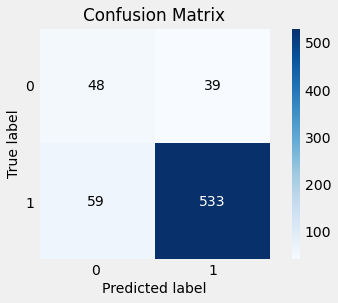

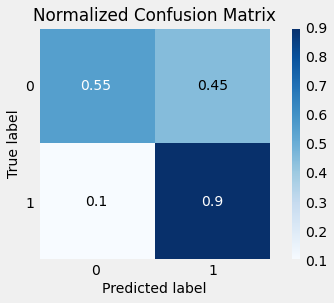

In [39]:
y_pred = grid.predict(X_test_Bi)
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(y_test_Bi, y_pred);
skplt.metrics.plot_confusion_matrix(y_test_Bi, y_pred, normalize=True);


In [40]:
print(metrics.classification_report(y_test_Bi,y_pred))
print(metrics.accuracy_score(y_test_Bi,y_pred))

              precision    recall  f1-score   support

           0       0.45      0.55      0.49        87
           1       0.93      0.90      0.92       592

    accuracy                           0.86       679
   macro avg       0.69      0.73      0.71       679
weighted avg       0.87      0.86      0.86       679

0.8556701030927835


# Multi Class Models

## Bayes <a class="anchor" id="MultiBayes"></a>

### Model

In [41]:
X_train_B = X_train_tfid_ex
y_train_B = y_train_tfid_ex
X_test_B = X_test_tfid_ex
y_test_B = y_test_tfid_ex



# MNB Params For Gridsearch
hyp_params_MNB = {
    'vect__ngram_range': [(1,1)], #(1,15) - 95, 89, (1,20) - 81,80
    'vect__min_df':[0],
    'tfidf__use_idf': [False],
    'tfidf__norm': (['l1']),#L1
    'clf__alpha': [10]}

#classifer = ComplementNB()
classifer = MultinomialNB()

estimator = Pipeline([
        ('vect', TfidfVectorizer()),('tfidf', TfidfTransformer()),('sampling', SMOTE(random_state=1)),('clf', classifer)
    ])


hyp_params = hyp_params_MNB

cv=10
jobs = -1

grid = GridSearchCV(estimator=estimator, param_grid=hyp_params,scoring='accuracy',cv=cv, n_jobs=jobs)
grid_result = grid.fit(X_train_B, y_train_B)

modelscore_Train = round(grid_result.score(X_train_B, y_train_B),2)
modelscore_Test = round(grid_result.score(X_test_B, y_test_B),2)

# print(f'Best Params: {params}')
print(f'Train Score: {modelscore_Train}')
print(f'Test Score: {modelscore_Test}')   
print("Best Parameters: \n{}\n".format(grid_result.best_params_))

Train Score: 0.62
Test Score: 0.57
Best Parameters: 
{'clf__alpha': 10, 'tfidf__norm': 'l1', 'tfidf__use_idf': False, 'vect__min_df': 0, 'vect__ngram_range': (1, 1)}



### Ploting Results with Confusion Matrix <a class="anchor" id="MultiBayesMatrix"></a>

Bayes - Confusion matrix, without normalization


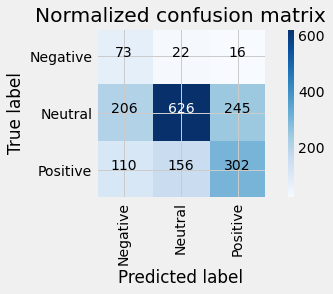

In [42]:
label_names = np.array(['Negative', 'Neutral', 'Positive'])

y_pred_B = grid.predict(X_test_B)
cnf_matrix = confusion_matrix(y_test_B, y_pred_B)

plot_confusion_matrix("Bayes",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=False, title='Normalized confusion matrix')



Bayes - Normalized confusion matrix here


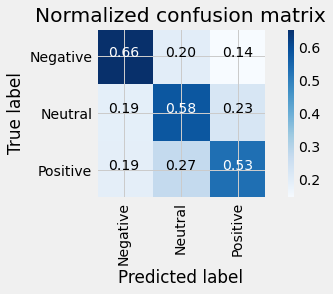

In [43]:
plot_confusion_matrix("Bayes",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=True, title='Normalized confusion matrix')

## RNN

### Examining OOV <a class="anchor" id="OOV"></a>

In [44]:
embedding_matrix_twitter_TFIDF = createEmbeddedMatrix1("TFIDF", vocab_size_tfidf, embedding_dim_twitter,embeddings_index_twitter)
embedding_matrix_google_TFIDF = createEmbeddedMatrix1("TFIDF",vocab_size_tfidf, embedding_dim_google,embeddings_index_google)

embedding_matrix_twitter_TFIDF_ex = createEmbeddedMatrix1("TFIDF_ex", vocab_size_tfifd_ex, embedding_dim_twitter,embeddings_index_twitter)
embedding_matrix_google_TFIDF_ex = createEmbeddedMatrix1("TFIDF_ex",vocab_size_tfifd_ex, embedding_dim_google,embeddings_index_google)


embedding_matrix_twitter_RNN = createEmbeddedMatrix1("RNN", vocab_size_RNN, embedding_dim_twitter,embeddings_index_twitter)
embedding_matrix_google_RNN = createEmbeddedMatrix1("RNN", vocab_size_RNN, embedding_dim_google,embeddings_index_google)

# determine nunmber of words we are missing from our vacab Twitter Word2vec

#RNN
oov_tw_RNN = check_coverage("word2vec", "twitter", vocab_RNN, embeddings_index_twitter)
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_g_RNN = check_coverage("word2vec", "google",vocab_RNN,embeddings_index_google)

print("\n")

# TFIDF
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_tw_TFIDF = check_coverage("TFIDF", "twitter", vocab_tfid,embeddings_index_twitter)
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_g_TFIDF = check_coverage("TFIDF", "google",vocab_tfid,embeddings_index_google)

print("\n")
# TFIDF_ex
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_tw_TFIDF_ex = check_coverage("TFIDF_ex", "twitter", vocab_tfid_ex,embeddings_index_twitter)
# determine nunmber of words we are missing from our vacab Twitter Word2vec
oov_g_TFIDF_ex = check_coverage("TFIDF_ex", "google",vocab_tfid_ex,embeddings_index_google)

Converted 1958 words (73 misses)
Converted 1958 words (80 misses)
Converted 704 words (19 misses)
Converted 704 words (17 misses)
Converted 8342 words (903 misses)
Converted 8342 words (1144 misses)
word2vec : twitter
Found embeddings for 89.175% of vocab
Found embeddings for  96.940% of all text
word2vec : google
Found embeddings for 86.286% of vocab
Found embeddings for  97.347% of all text


TFIDF : twitter
Found embeddings for 96.223% of vocab
Found embeddings for  96.044% of all text
TFIDF : google
Found embeddings for 95.916% of vocab
Found embeddings for  98.691% of all text


TFIDF_ex : twitter
Found embeddings for 97.301% of vocab
Found embeddings for  96.560% of all text
TFIDF_ex : google
Found embeddings for 97.585% of vocab
Found embeddings for  99.104% of all text


In [45]:
# check top words that will not be accounted for in our embedding layer/ not in our pretrained Word2vec - TWitter
oov_tw_RNN[:10]

[('2', 221),
 ('3', 167),
 ('4', 165),
 ('1', 123),
 ('5', 108),
 ('6th', 99),
 ('bebecause', 79),
 ('7', 69),
 ('uberguide', 69),
 ('qamp', 40)]

In [46]:
# check top words that will not be accounted for in our embedding layer/ not in our pretrained Word2vec - Google
oov_g_RNN[:10]

[('marissa', 193),
 ('bebecause', 79),
 ('uberguide', 69),
 ('flipboard', 49),
 ('qamp', 40),
 ('circlesquot', 39),
 ('hootsuite', 39),
 ('conferencesquot', 35),
 ('diller', 29),
 ('upquot', 27)]

### Model <a class="anchor" id="RNN"></a>

In [48]:
# RNN using less Complex Dataset

X_train1 = X_train_padded_docs_tfidf_ex
y_train1 = y_train_1hot_tfidf_ex

X_test1 = X_test_padded_docs_tfidf_ex
y_test1 = y_test_1hot_tfidf_ex


def createDeepLearningModel(optimizer='adam',dropout_rate=0.0):
    model = Sequential()
    #e = Embedding(vocab_size_RNN, max_length, input_length=max_length, trainable=False)
    e = Embedding(vocab_size_tfifd_ex,  # number of unique tokens +1
                  200, #number of features
                  weights=[embedding_matrix_twitter_TFIDF_ex],# initialize 
                  input_length=X_train1.shape[1])
    #embeddings_initializer=Constant([embedding_matrix])
    #trainable=False
    
    model.add(e)
    #model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train1.shape[1],embedding_dim))))
    model.add(Bidirectional(LSTM(100, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    #model.add(Dropout(dropout_rate))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model


hyp_params_RNN = [{
            'dropout_rate':[0.4],
            'batch_size':[100],
            'nb_epoch':[10, 15],
            'optimizer':['adam']
            #'clf__neurons':[50,100]
        }]

kears_estimator = KerasClassifier(build_fn=createDeepLearningModel, verbose=1)

grid_RNN = GridSearchCV(estimator=kears_estimator,param_grid=hyp_params_RNN,cv=10, n_jobs=-1, return_train_score=True)

grid_result  = grid_RNN.fit(X_train1, y_train1, class_weight=d_class_weights_RNN,validation_data=(X_test1,y_test1),
                            callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.01)])
                            # callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                            #EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
modelscore_Train = round(grid_result.score(X_train1, y_train1),2)
modelscore_Test = round(grid_result.score(X_test1, y_test1),2)
print(f'Train Scores: {modelscore_Train}')
print(f'Test Scores: {modelscore_Test}')

62/62 [==============================] - 13s 105ms/step - loss: 1.0507 - accuracy: 0.4481 - val_loss: 0.9717 - val_accuracy: 0.5440
Best: 0.540939 using {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 10, 'optimizer': 'adam'}
0.540939 (0.054377) with: {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 10, 'optimizer': 'adam'}
0.529064 (0.052083) with: {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 15, 'optimizer': 'adam'}
27/27 [==============================] - 0s 10ms/step - loss: 0.9717 - accuracy: 0.5440
Train Scores: 0.55
Test Scores: 0.54


In [49]:
# RNN using More Complex Dataset

X_train1 = X_train_padded_docs
y_train1 = y_train_1hot

X_test1 = X_test_padded_docs
y_test1 = y_test_1hot



def createDeepLearningModel(optimizer='adam',dropout_rate=0.0):
    model = Sequential()
    #e = Embedding(vocab_size_RNN, max_length, input_length=max_length, trainable=False)
    e = Embedding(vocab_size_RNN,  # number of unique tokens +1
                  300, #number of features
                  weights=[embedding_matrix_google_RNN],# initialize 
                  input_length=X_train1.shape[1])
    #embeddings_initializer=Constant([embedding_matrix])
    #trainable=False
    
    model.add(e)
    #model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(X_train1.shape[1],embedding_dim))))
    model.add(Bidirectional(LSTM(100, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    #model.add(Dropout(dropout_rate))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model


hyp_params_RNN = [{
            'dropout_rate':[0.4],
            'batch_size':[100],
            'nb_epoch':[10, 15],
            'optimizer':['adam']
            #'clf__neurons':[50,100]
        }]

kears_estimator = KerasClassifier(build_fn=createDeepLearningModel, verbose=1)

grid_RNN = GridSearchCV(estimator=kears_estimator,param_grid=hyp_params_RNN,cv=10, n_jobs=-1, return_train_score=True)

grid_result  = grid_RNN.fit(X_train1, y_train1, class_weight=d_class_weights_RNN,validation_data=(X_test1,y_test1),
                            callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.01)])
                            # callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                            #EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
modelscore_Train = round(grid_result.score(X_train1, y_train1),2)
modelscore_Test = round(grid_result.score(X_test1, y_test1),2)
print(f'Train Scores: {modelscore_Train}')
print(f'Test Scores: {modelscore_Test}')

62/62 [==============================] - 23s 269ms/step - loss: 1.0531 - accuracy: 0.4357 - val_loss: 0.8801 - val_accuracy: 0.5831
Best: 0.524803 using {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 10, 'optimizer': 'adam'}
0.524803 (0.074519) with: {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 10, 'optimizer': 'adam'}
0.485934 (0.100667) with: {'batch_size': 100, 'dropout_rate': 0.4, 'nb_epoch': 15, 'optimizer': 'adam'}
27/27 [==============================] - 1s 39ms/step - loss: 0.8801 - accuracy: 0.5831
Train Scores: 0.61
Test Scores: 0.58


### Ploting Results with Confusion Matrix <a class="anchor" id="RNNMatrix"></a>

27/27 [==============================] - 1s 26ms/step
RNN - Confusion matrix, without normalization




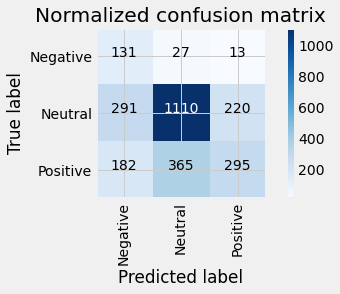

In [50]:
label_names = np.array(['Negative', 'Neutral', 'Positive'])

Probabilties = grid_RNN.predict_proba(X_test1)
cnf_matrix = confusion_matrix(np.argmax(y_test1, axis=1), np.argmax(Probabilties, axis=1))

plot_confusion_matrix("RNN",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=False, title='Normalized confusion matrix')
print("\n")



RNN - Normalized confusion matrix here


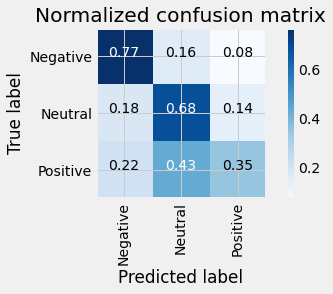

In [51]:
plot_confusion_matrix("RNN",cnf_matrix, classes=np.asarray(label_names), 
                      normalize=True, title='Normalized confusion matrix')

# Conclusion <a class="anchor" id="Conclusions"></a>

OBSERVATIONS Data Processing:
* `Dealing with an imbalanced dataset, need to smote`
* `Several words in corpus occur only once or less than 4 times, need to remove`
* `Several words in corpus are similar in meaning required to consolidate words with the same meaning to improve classification`
* `Used Chi2 to improve classification results, needed to ensure to keep high scoring words that were unique to either positive or negative`
* `Experimented eliminating words that occured frequently in both negative and positive sentiments as those would just confuse/ make the model more complex`

OBSERVATIONS Modeling:
* `Bianary - class: After several iterations of cleanning data and tunning pipeline parameters, acheive 86% accuracy with little to no overfitting`
* `Multi - class: After several iterations through trying to tune multiclass classifiers, could not reach satifactory accuracy results`

# Pickle Files <a class="anchor" id="CreatePickle"></a>

In [ ]:

#Create Files for Modeling
with open('df_data.pickle', 'wb') as f:
    pickle.dump(df_data, f)
    

#Create Files for Modeling
with open('df_data_binary.pickle', 'wb') as f:
    pickle.dump(df_data_binary, f)